In [40]:
import random
import math
import numpy as np
from collections import namedtuple, deque
import matplotlib.pyplot as plt
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

Resource: https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html

In [2]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):
    '''
        The memory reply class
    '''
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        self.memory.append(Transition(*args))
    
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)


# Q-network

In [3]:
class DQN(nn.Module):
    def __init__(self, n_actions):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=1, stride=1, padding=2)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=2)
        self.bn2 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(2)
        self.conv3 = nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=2)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, n_actions, kernel_size=3, stride=1)
        self.n_actions = n_actions
    def forward(self, x):
        x = x.to(device)
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.bn2(x)
        x = self.pool(F.relu(self.conv3(x)))
        x = self.bn3(x)
        x = F.relu(self.conv4(x))
        x = F.adaptive_avg_pool2d(x, output_size=1)
        return x.view(x.size(0), -1) # will return batch size x 1 the action choosen for that state

In [4]:
model = DQN(5).to(device)
model

DQN(
  (conv1): Conv2d(3, 64, kernel_size=(1, 1), stride=(1, 1), padding=(2, 2))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 5, kernel_size=(3, 3), stride=(1, 1))
)

# World

In [4]:
class World():
    def __init__(self, path_to_infile, path_to_outfile):
        self.path_to_outfile = path_to_outfile
        self.path_to_infile = path_to_infile

        self.grid = self.extract_grid()
        self.grid_h = len(self.grid)
        self.grid_w = len(self.grid[0])
        self.desirable_area, self.d_area_center = self.find_desirable_area()
        self.n_parts = 0
        self.cargos = self.find_cargos()
        self.n_cargos = len(self.cargos.keys())
        self.one_vs_all = self.extract_one_vs_all()
        self.actions_map = {
        1: self.move_up,
        2: self.move_down,
        3: self.move_right,
        4: self.move_left
        }


    def extract_grid(self):
        """ extracting the grid from the input file """
        grid_list = []
        with open(rf'{self.path_to_infile}', 'r') as f:
            lines = f.readlines()
        for line in lines:
            line = line.replace('\n','')
            line = line.split(' ')
            grid_list.append(line)
        grid = np.zeros((len(grid_list), len(grid_list[0])))
        for i in range(len(grid)):
          for j in range(len(grid[0])):
            if grid_list[i][j].isdigit():
              grid[i][j] = int(grid_list[i][j])
            else:
              grid[i][j] = 0.1
        return grid


    def find_cargos(self):
        """
            Seach in the grid for all the cargos and add it to a dictionary
        """
        cargos = {}
        for i in range(self.grid_h):
            for j in range(self.grid_w):
                if self.grid[i][j] != 0.1:
                    if self.grid[i][j] > 0.0:
                        if cargos.get(str(self.grid[i][j])):
                            cargos[str(self.grid[i][j])].append([i, j])
                        else:
                            cargos[str(self.grid[i][j])] = [[i, j]]
                        self.n_parts += 1
        return cargos


    def extract_one_vs_all(self):
        """
            Will return a dictionary containg the cargo number as a key and 
            the indices of all the other cargos as the value
        """
        one_vs_all = {} 
        for cargo_number, _ in self.cargos.items():
            one_vs_all[cargo_number] = []
        for cn, cargo_parts in self.cargos.items():
            if cn != cargo_number:
                one_vs_all[cargo_number].extend(cargo_parts)
        return one_vs_all
    

    def find_desirable_area(self):
        """
            Extract the desirable area from the grid
        """
        desirable_area = []
        top_left = [100000, 100000] # should be min in x and y axis
        top_right = [10000, -1] # should be min in x and max in y axis
        bottom_left = [-1, 100000] # should be max in x and min in y axis
        bottom_right = [-1, -1] # should be max in x and y axis
        for i in range(self.grid_h):
            for j in range(self.grid_w):
                if self.grid[i][j] == 0.1:
                    desirable_area.append(f'{i}_{j}')
                    if i < top_left[0] and j < top_left[1]:
                      top_left = [i, j]
                    if i > bottom_left[0] and j <= bottom_left[1]:
                      bottom_left = [i, j]
                    if i >= bottom_right[0] and j >= bottom_right[1]:
                      bottom_right = [i,j]
        center = [(top_left[0] + bottom_left[0])/2, (bottom_left[1] + bottom_right[1])/2]
        return desirable_area, center

    def get_current_grid(self):
        return self.grid
    
    def reset(self):
        """
            Generate a random grid.
            The idea behind it is explained in the report
        """
        while True:
            valid = False
            # determing grid size:
            grid_h = np.random.randint(3, 20)
            grid_w = np.random.randint(3, 20)
            
            grid = np.zeros((grid_h, grid_w))

            # determing the size of the desirable area
            d_area_h = np.random.randint(1, grid_h)
            d_area_w = np.random.randint(1, grid_w)

            d_area_row = np.random.randint(0, grid_h-d_area_h)
            d_area_col = np.random.randint(0, grid_w-d_area_w)
            for i in range(d_area_row, d_area_row + d_area_h):
                for j in range(d_area_col, d_area_col + d_area_w):
                    grid[i][j] = 0.1

            # determining the number of cargos in the grid
            if d_area_h + d_area_w == 1:
                n_cargos = 1
            else:
                n_cargos = random.randint(1, max(d_area_w, d_area_h))
            area_covered = 0
            for cargo_number in range(1, n_cargos+1):
                # image if the cargo shape is recatnagular then we will drop some of its parts
                if d_area_h == 1:
                    cargo_h = 1
                else:
                    cargo_h = np.random.randint(1, d_area_h)
                if d_area_w == 1:
                    cargo_w = 1
                else:
                    cargo_w = np.random.randint(1, d_area_w)
                area_covered += cargo_h * cargo_w
                if area_covered > (d_area_h*d_area_w):
                    area_covered -= cargo_h * cargo_w
                    continue
                # choosing the cargo place on the grid
                cargo_row = np.random.randint(0, grid_h-cargo_h)
                cargo_col = np.random.randint(0, grid_w-cargo_w)
                n_cargo_parts = 0
                cargo_threshold = random.random()
                for i in range(cargo_row, cargo_row + cargo_h):
                    for j in range(cargo_col, cargo_col+cargo_w):
                        if grid[i][j] == 0 and random.random() > cargo_threshold:
                            grid[i][j] = cargo_number
                            n_cargo_parts += 1
                            valid = True
            if valid:
                self.grid = grid
                self.grid_h = len(self.grid)
                self.grid_w = len(self.grid[0])
                self.desirable_area, self.d_area_center = self.find_desirable_area()
                self.n_parts = 0
                self.cargos = self.find_cargos()
                self.n_cargos = len(self.cargos.keys())
                self.one_vs_all = self.extract_one_vs_all()
                return


    def calculate_reward(self):
        """
            Calculate the reward for parts inside the desirable area
        """
        reward = 0
        coverd = {s: False for s in self.desirable_area}
        for cargo_number, cargo_parts in self.cargos.items():
            for part in cargo_parts:
                if f'{part[0]}_{part[1]}' in self.desirable_area:
                    if coverd[f'{part[0]}_{part[1]}']:
                        reward -= 1
                    else:
                        reward += 1
                        coverd[f'{part[0]}_{part[1]}'] = True
        return reward
    

    def reached_terminal(self):
        """
            Check if we reached the terminal state or not
        """
        coverd = {s: False for s in self.desirable_area}
        counter = 0
        for cargo_number, cargo_parts in self.cargos.items():
            for part in cargo_parts:
                if f'{part[0]}_{part[1]}' in self.desirable_area and not coverd[f'{part[0]}_{part[1]}']:
                    counter += 1
                    coverd[f'{part[0]}_{part[1]}'] = True
        if counter == self.n_parts:
            return True
        return False


    def calc_distance_to_desirable(self, cargo_number):
        """
            returns the negative eclidian distance between an object and the desirable area
        """
        cargo_parts = self.cargos[cargo_number]
        x1, y1 = self.d_area_center
        x2 = self.cargos[cargo_number][0][0]
        y2 = self.cargos[cargo_number][0][1]
        result = -((x1-x2)*(x1-x2) + (y1-y2)*(y1-y2)) # negative squared euclidean distance 
        return result
        
    def cargo_inside(self, cargo_number):
      cargo_parts = self.cargos[cargo_number]
      inside = False
      for part in cargo_parts:
          if f'{part[0]}_{part[1]}' in self.desirable_area:
              inside = True
      if inside:
          return True
      else:
          return False
    def step(self, action, cargo_number):
        """
            preform an action on cargo with cargo_number and return
            if this action preformed or not, reward, reached terminal or not
        """
        cargo_number = str(cargo_number)
        if action == 0:
            # if action is rest and the cargo isn't fully inside the desirable area then return negative reward
            if self.cargo_inside(cargo_number):
                return True, 0, False
            else:
                return True, -1, False

        avg_distance_before = self.calc_distance_to_desirable(cargo_number) # calculating the negative ecludian distance to the center of the desirable area
        reward_before = self.calculate_reward()
        if self.actions_map[action](cargo_number):
            if self.reached_terminal():
                print('reached_terminal')
                return True, self.n_parts, True
            else:
                reward = self.calculate_reward()
                if not self.cargo_inside(cargo_number):
                  avg_distance_after = self.calc_distance_to_desirable(cargo_number)
                  if avg_distance_after > avg_distance_before:
                      reward += 1
                  else:
                      reward -= 1
                reward = -1 if reward_before > reward else reward # calculating the delta reward
                return True, reward, False
        return False, -1, False # this move leeds to crossing the boarder 
    

    def move_up(self, cargo_number):
        """
            preform the action of moving up
        """
        for i in range(len(self.cargos[cargo_number])):
            if self.cargos[cargo_number][i][0] - 1 < 0:
                return False

        old_cargo_values = []
        for i in range(len(self.cargos[cargo_number])): 
            old_cargo_values.append([self.cargos[cargo_number][i][0], self.cargos[cargo_number][i][1]])
            self.cargos[cargo_number][i][0] -= 1

        self.update_grid(cargo_number, old_cargo_values)
        return True


    def move_down(self, cargo_number):
        """
            preform the action of moving down
        """
        for i in range(len(self.cargos[cargo_number])):
            if self.cargos[cargo_number][i][0] + 1 >= self.grid_h:
                return False

        old_cargo_values = []
        for i in range(len(self.cargos[cargo_number])):
            old_cargo_values.append([self.cargos[cargo_number][i][0], self.cargos[cargo_number][i][1]])
            self.cargos[cargo_number][i][0] += 1

        self.update_grid(cargo_number, old_cargo_values)
        return True

    def move_right(self, cargo_number):
        """
            preform the action of moving right
        """
        for i in range(len(self.cargos[cargo_number])):
            if self.cargos[cargo_number][i][1] + 1 >= self.grid_w:
                return False
        
        old_cargo_values = []
        for i in range(len(self.cargos[cargo_number])):
            old_cargo_values.append([self.cargos[cargo_number][i][0], self.cargos[cargo_number][i][1]])
            self.cargos[cargo_number][i][1] += 1
            

        self.update_grid(cargo_number, old_cargo_values)
        return True
    
    def move_left(self, cargo_number):
        """
            preform the action of moving left
        """
        for i in range(len(self.cargos[cargo_number])):
            if self.cargos[cargo_number][i][1] - 1 < 0:
                return False

        old_cargo_values = []
        for i in range(len(self.cargos[cargo_number])):
            old_cargo_values.append([self.cargos[cargo_number][i][0], self.cargos[cargo_number][i][1]])
            self.cargos[cargo_number][i][1] -= 1
        
        self.update_grid(cargo_number, old_cargo_values)
        return True

    def update_grid(self, cargo_number, old_cargo_values):
        """
            update the grid after an action is preformed
        """
        for part in old_cargo_values:
            if self.grid[part[0]][part[1]] != 0.1:
                self.grid[part[0]][part[1]] = 0
        for i in range(len(self.cargos[cargo_number])):
            if self.grid[self.cargos[cargo_number][i][0]][self.cargos[cargo_number][i][1]] != 0.1:
                self.grid[self.cargos[cargo_number][i][0]][self.cargos[cargo_number][i][1]] = cargo_number

    def print_grid(self):
        """
            prints the grid
        """
        for i in range(len(self.grid)):
            for j in range(len(self.grid[0])):
                print(self.grid[i][j], end=' ')
            print()
        print()

# Input extraction

In [5]:
def merge_grid_with_cargo(state, desirable_area, cargo, cargo_number, grid_h, grid_w, world):
    '''
      States are tensors with 3 channels:
      - First channel contains the desirable area
      - Second channel contains the target cargo 
      - Third channel contains the other cargos
    '''
    channel_1 = torch.zeros(grid_h, grid_w)
    channel_2 = torch.zeros(grid_h, grid_w)
    channel_3 = torch.zeros(grid_h, grid_w)
    for i in range(grid_h):
      for j in range(grid_w):
        if f'{i}_{j}' in desirable_area:
          channel_1[i][j] = 1
        if [i,j] in cargo:
          channel_2[i][j] = 1
        if [i,j] in world.one_vs_all[cargo_number]:
          channel_3[i][j] = 1

    return torch.stack((channel_1, channel_2, channel_3))

# Hyperparameters and utilities

In [6]:
def get_next_cargo(world, cargo_number):
  """
    gets the cargo that is next in turn
  """
  cargo_numbers = list(world.cargos.keys())
  if cargo_numbers.index(cargo_number) + 1 >= len(cargo_numbers):
    return cargo_numbers[0]
  return str(cargo_numbers[cargo_numbers.index(cargo_number)+1])

In [13]:
# Hyperparameters
BATCH_SIZE = 32
GAMMA = 0.999
EPS_START = 0.5
EPS_END = 0.1
EPS_DECAY = 800
TARGET_UPDATE = 10

N_ACTIONS = 5 # (stay where you are, up, down, right, left)
MEMORY_SIZE = 10_000
possible_actions = ['Rest', 'U', 'D', 'R', 'L']
steps_done = 0

episode_durations = [] # steps until terminal

policy_net = DQN(N_ACTIONS).to(device)
target_net = DQN(N_ACTIONS).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()
optimizer = optim.RMSprop(policy_net.parameters(), lr=1e-4)

In [14]:
def select_action(state):
    """
        select an action by applying epsilon greedy
    """
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    # print(eps_threshold)
    if sample > eps_threshold:
        with torch.no_grad(): 
            state = state.to(device)
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(N_ACTIONS)]], device=device, dtype=torch.long)


def plot_durations():
    """
        plot the number of steps the model took to reach terminal
    """
    plt.figure(2)
    plt.clf()
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Steps')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated


In [15]:
def optimize_model(memory):
    """
      optimize the model using the deep Q-learning algorithm 
    """
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))
    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.tensor(batch.action)
    reward_batch = torch.cat(batch.reward)
    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch.unsqueeze(1).to(device))

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    state_action_values = state_action_values.type(torch.float)
    state_action_values.requires_grad_()
    loss = criterion(state_action_values.squeeze(), expected_state_action_values)

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    for p in policy_net.parameters():
      p.register_hook(lambda grad: torch.clamp(grad, -1, 1))
    optimizer.step()

Running episode 0, training on map 9
0.0 0.0 0.1 0.1 0.1 0.1 
0.0 0.0 0.0 0.0 0.1 0.1 
0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 
1.0 1.0 1.0 1.0 0.0 0.0 
0.0 0.0 1.0 0.0 0.0 2.0 

Optimizing on map 9
Optimizing on map 9
Optimizing on map 9
Optimizing on map 9
Optimizing on map 9
Optimizing on map 9
Optimizing on map 9
Running episode 1, training on map 5
0.1 0.1 0.0 0.0 
0.1 0.1 0.0 0.0 
0.0 0.0 0.0 1.0 
2.0 2.0 0.0 0.0 

Optimizing on map 9
Optimizing on map 9
Optimizing on map 9
Optimizing on map 9
Optimizing on map 5
Optimizing on map 9
Optimizing on map 5
Optimizing on map 9
Optimizing on map 9
Optimizing on map 5
Optimizing on map 9
Optimizing on map 9
Optimizing on map 5
Running episode 2, training on map 0
1.0 0.0 
0.0 0.1 

Optimizing on map 9
Optimizing on map 5
Optimizing on map 5
reached_terminal


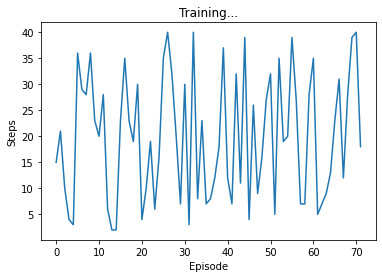

Running episode 3, training on map 3
1.0 2.0 0.0 
0.0 0.0 0.0 
0.0 0.1 0.1 

Optimizing on map 9
Optimizing on map 9
Optimizing on map 5
Optimizing on map 9
Optimizing on map 5
Optimizing on map 9
Optimizing on map 5
Optimizing on map 5
Optimizing on map 5
Optimizing on map 9
Optimizing on map 9
Optimizing on map 3
Optimizing on map 5
Optimizing on map 9
Optimizing on map 9
Optimizing on map 3
Optimizing on map 3
Optimizing on map 5
Optimizing on map 3
Optimizing on map 3
Optimizing on map 5
Running episode 4, training on map 8
0.0 0.0 4.0 4.0 4.0 4.0 
0.0 0.0 0.0 0.0 0.0 0.0 
0.1 0.1 0.1 0.1 0.1 0.0 
0.1 0.1 0.1 0.1 0.1 0.0 
0.0 0.0 0.0 0.0 0.0 1.0 
0.0 0.0 0.0 0.0 0.0 1.0 

Optimizing on map 9
Optimizing on map 9
Optimizing on map 5
Optimizing on map 9
Optimizing on map 3
Optimizing on map 9
Optimizing on map 8
Optimizing on map 9
Optimizing on map 3
Optimizing on map 8
Optimizing on map 5
Optimizing on map 5
Optimizing on map 9
Optimizing on map 9
Optimizing on map 3
Optimizing on m

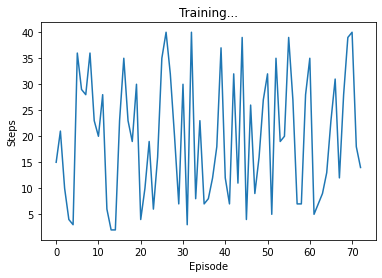

Running episode 10, training on map 4
0.0 0.0 1.0 
0.0 2.0 0.0 
0.0 0.1 0.1 

Optimizing on map 5
Optimizing on map 9
Optimizing on map 5
Optimizing on map 3
Optimizing on map 0
Optimizing on map 3
Optimizing on map 0
reached_terminal
Optimizing on map 3


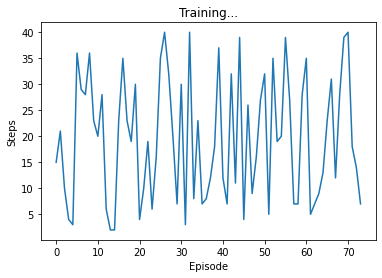

Running episode 11, training on map 1
0.1 0.0 0.0 
0.0 0.0 0.0 
0.0 0.0 1.0 

Optimizing on map 5
Optimizing on map 3
Optimizing on map 8
Optimizing on map 0
Optimizing on map 9
Optimizing on map 3
Optimizing on map 0
Optimizing on map 9
Optimizing on map 5
Optimizing on map 9
Optimizing on map 5
Optimizing on map 5
Optimizing on map 9
Optimizing on map 9
Optimizing on map 3
Optimizing on map 9
Optimizing on map 0
Optimizing on map 0
Optimizing on map 5
Running episode 12, training on map 0
1.0 0.0 
0.0 0.1 

Optimizing on map 8
Optimizing on map 9
Optimizing on map 1
Optimizing on map 5
Optimizing on map 5
Optimizing on map 5
Optimizing on map 0
Optimizing on map 0
Optimizing on map 0
Optimizing on map 5
Optimizing on map 1
Optimizing on map 0
Optimizing on map 0
Optimizing on map 3
Optimizing on map 3
Optimizing on map 9
Optimizing on map 0
Running episode 13, training on map 3
1.0 2.0 0.0 
0.0 0.0 0.0 
0.0 0.1 0.1 

Optimizing on map 5
Optimizing on map 9
Optimizing on map 1
Optimiz

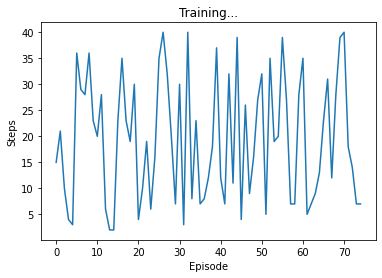

Running episode 14, training on map 1
0.1 0.0 0.0 
0.0 0.0 0.0 
0.0 0.0 1.0 

Optimizing on map 5
Optimizing on map 5
Optimizing on map 5
Optimizing on map 1
Optimizing on map 9
Optimizing on map 0
Optimizing on map 5
Optimizing on map 5
Optimizing on map 5
Optimizing on map 9
Optimizing on map 5
Optimizing on map 5
Optimizing on map 5
Optimizing on map 3
Optimizing on map 9
Optimizing on map 8
Optimizing on map 1
Optimizing on map 9
Optimizing on map 0
Running episode 15, training on map 1
0.1 0.0 0.0 
0.0 0.0 0.0 
0.0 0.0 1.0 

Optimizing on map 0
Optimizing on map 1
Optimizing on map 3
Optimizing on map 8
Optimizing on map 3
Optimizing on map 1
Optimizing on map 5
Optimizing on map 8
Optimizing on map 0
Optimizing on map 9
Optimizing on map 1
Running episode 16, training on map 10
0.0 0.0 2.0 2.0 0.0 
0.0 0.1 0.1 0.1 0.0 
0.0 0.1 0.1 0.1 1.0 
0.0 0.1 0.1 0.1 1.0 
0.0 0.0 0.0 0.0 1.0 

Optimizing on map 0
Optimizing on map 8
Optimizing on map 1
Optimizing on map 8
Optimizing on map 3

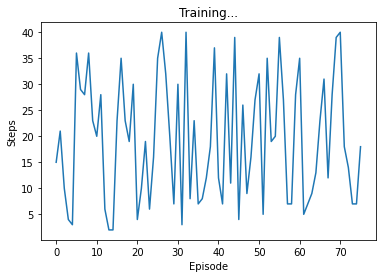

Running episode 17, training on map 0
1.0 0.0 
0.0 0.1 

Optimizing on map 1
Optimizing on map 10
Optimizing on map 9
Optimizing on map 1
Optimizing on map 10
Optimizing on map 3
Optimizing on map 8
Optimizing on map 5
Optimizing on map 3
Optimizing on map 3
Optimizing on map 3
Optimizing on map 5
Optimizing on map 5
Optimizing on map 9
Optimizing on map 1
Optimizing on map 3
Optimizing on map 9
Optimizing on map 8
Optimizing on map 3
Optimizing on map 5
Optimizing on map 3
Optimizing on map 9
Optimizing on map 3
Optimizing on map 0
Optimizing on map 0
Optimizing on map 8
Optimizing on map 1
Optimizing on map 9
Running episode 18, training on map 1
0.1 0.0 0.0 
0.0 0.0 0.0 
0.0 0.0 1.0 

Optimizing on map 9
Optimizing on map 1
Optimizing on map 0
Optimizing on map 10
Optimizing on map 10
Optimizing on map 8
Optimizing on map 10
Optimizing on map 8
Optimizing on map 10
Optimizing on map 5
Optimizing on map 8
Optimizing on map 3
Optimizing on map 3
Optimizing on map 10
Optimizing on map 

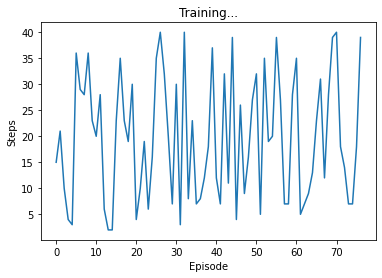

Running episode 22, training on map 9
0.0 0.0 0.1 0.1 0.1 0.1 
0.0 0.0 0.0 0.0 0.1 0.1 
0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 
1.0 1.0 1.0 1.0 0.0 0.0 
0.0 0.0 1.0 0.0 0.0 2.0 

Optimizing on map 10
Optimizing on map 10
Optimizing on map 10
Optimizing on map 5
Optimizing on map 9
Optimizing on map 9
Optimizing on map 1
Optimizing on map 10
Optimizing on map 10
Optimizing on map 8
Optimizing on map 5
Optimizing on map 3
Optimizing on map 3
Optimizing on map 3
Optimizing on map 3
Optimizing on map 0
Optimizing on map 0
Optimizing on map 0
Optimizing on map 9
Optimizing on map 3
Optimizing on map 5
Optimizing on map 9
Optimizing on map 0
Optimizing on map 9
Optimizing on map 5
Optimizing on map 10
Optimizing on map 10
Optimizing on map 1
Optimizing on map 9
Optimizing on map 3
Optimizing on map 5
Optimizing on map 3
Optimizing on map 3
Optimizing on map 5
Optimizing on map 5
Optimizing on map 0
Optimizing on map 0
Optimizing on map 5
Optimizing on map 9
Optimizing on map 10
Opt

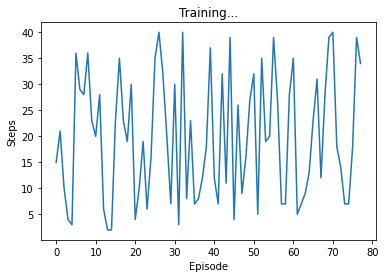

Running episode 29, training on map 4
0.0 0.0 1.0 
0.0 2.0 0.0 
0.0 0.1 0.1 

Optimizing on map 5
Optimizing on map 10
Optimizing on map 6
Optimizing on map 1
Optimizing on map 1
Optimizing on map 0
Optimizing on map 7
Optimizing on map 6
Optimizing on map 5
reached_terminal
Optimizing on map 5


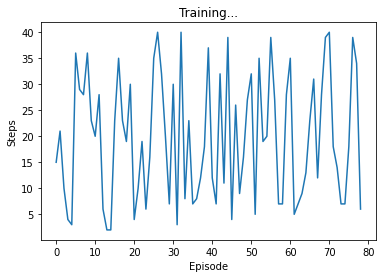

Running episode 30, training on map 4
0.0 0.0 1.0 
0.0 2.0 0.0 
0.0 0.1 0.1 

Optimizing on map 0
Optimizing on map 3
Optimizing on map 7
Optimizing on map 8
Optimizing on map 0
Optimizing on map 3
Optimizing on map 0
Optimizing on map 8
Optimizing on map 5
Optimizing on map 10
Optimizing on map 8
Optimizing on map 0
Optimizing on map 5
reached_terminal
Optimizing on map 4


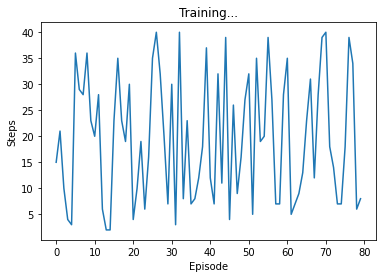

Running episode 31, training on map 0
1.0 0.0 
0.0 0.1 

Optimizing on map 3
Optimizing on map 4
Optimizing on map 1
Optimizing on map 0
Optimizing on map 9
Optimizing on map 10
Optimizing on map 0
Optimizing on map 5
Optimizing on map 0
Optimizing on map 0
Optimizing on map 4
Optimizing on map 7
Optimizing on map 0
Optimizing on map 3
Optimizing on map 3
Optimizing on map 10
Optimizing on map 1
Optimizing on map 4
Optimizing on map 1
Optimizing on map 7
Optimizing on map 8
Optimizing on map 1
Optimizing on map 0
Optimizing on map 7
Optimizing on map 10
Optimizing on map 10
Optimizing on map 8
Optimizing on map 0
Optimizing on map 1
Optimizing on map 8
Optimizing on map 6
Optimizing on map 3
Optimizing on map 4
Optimizing on map 7
Optimizing on map 5
Optimizing on map 9
Optimizing on map 3
Optimizing on map 5
Running episode 32, training on map 10
0.0 0.0 2.0 2.0 0.0 
0.0 0.1 0.1 0.1 0.0 
0.0 0.1 0.1 0.1 1.0 
0.0 0.1 0.1 0.1 1.0 
0.0 0.0 0.0 0.0 1.0 

Optimizing on map 9
Optimizing on 

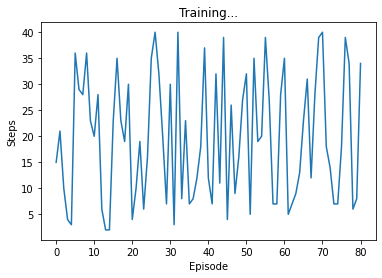

Running episode 34, training on map 8
0.0 0.0 4.0 4.0 4.0 4.0 
0.0 0.0 0.0 0.0 0.0 0.0 
0.1 0.1 0.1 0.1 0.1 0.0 
0.1 0.1 0.1 0.1 0.1 0.0 
0.0 0.0 0.0 0.0 0.0 1.0 
0.0 0.0 0.0 0.0 0.0 1.0 

Optimizing on map 5
Optimizing on map 0
Optimizing on map 3
Optimizing on map 10
Optimizing on map 4
Optimizing on map 4
Optimizing on map 8
Optimizing on map 6
Optimizing on map 7
Optimizing on map 6
Optimizing on map 0
Optimizing on map 9
Optimizing on map 1
Optimizing on map 4
Optimizing on map 6
Optimizing on map 4
Optimizing on map 5
Optimizing on map 7
Optimizing on map 8
Optimizing on map 8
Optimizing on map 1
Optimizing on map 0
Optimizing on map 5
Optimizing on map 3
Optimizing on map 10
Optimizing on map 6
Optimizing on map 9
Optimizing on map 9
Optimizing on map 5
Optimizing on map 3
Optimizing on map 6
Optimizing on map 3
Optimizing on map 8
Optimizing on map 3
Optimizing on map 9
Optimizing on map 6
Optimizing on map 10
Optimizing on map 9
Optimizing on map 6
Optimizing on map 0
Optimizi

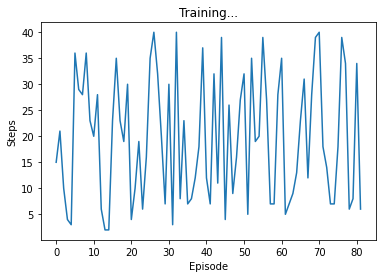

Running episode 36, training on map 0
1.0 0.0 
0.0 0.1 

Optimizing on map 10
Optimizing on map 7
Optimizing on map 6
Optimizing on map 6
Optimizing on map 3
Optimizing on map 4
Optimizing on map 10
Optimizing on map 3
Optimizing on map 8
Optimizing on map 6
Optimizing on map 9
Optimizing on map 7
Optimizing on map 7
Optimizing on map 7
Optimizing on map 3
Optimizing on map 7
Optimizing on map 7
Optimizing on map 9
Optimizing on map 0
Optimizing on map 5
Optimizing on map 1
Optimizing on map 8
Optimizing on map 0
Optimizing on map 9
Optimizing on map 4
Optimizing on map 5
Optimizing on map 7
Optimizing on map 10
Optimizing on map 4
Optimizing on map 3
Optimizing on map 0
Optimizing on map 8
Optimizing on map 0
Optimizing on map 7
Optimizing on map 5
Optimizing on map 1
Optimizing on map 9
Optimizing on map 8
Running episode 37, training on map 1
0.1 0.0 0.0 
0.0 0.0 0.0 
0.0 0.0 1.0 

Optimizing on map 3
Optimizing on map 4
Optimizing on map 9
Optimizing on map 4
Optimizing on map 1
Op

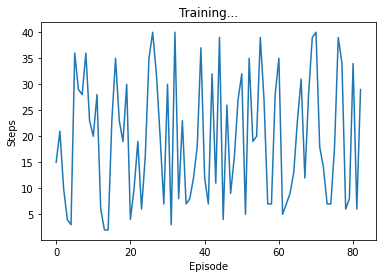

Running episode 40, training on map 8
0.0 0.0 4.0 4.0 4.0 4.0 
0.0 0.0 0.0 0.0 0.0 0.0 
0.1 0.1 0.1 0.1 0.1 0.0 
0.1 0.1 0.1 0.1 0.1 0.0 
0.0 0.0 0.0 0.0 0.0 1.0 
0.0 0.0 0.0 0.0 0.0 1.0 

Optimizing on map 9
Optimizing on map 5
Optimizing on map 6
Optimizing on map 5
Optimizing on map 6
Optimizing on map 6
Optimizing on map 8
Optimizing on map 3
Optimizing on map 4
Optimizing on map 5
Optimizing on map 0
Optimizing on map 9
Optimizing on map 8
Optimizing on map 10
Optimizing on map 3
Optimizing on map 5
Optimizing on map 10
Optimizing on map 9
Optimizing on map 5
Optimizing on map 1
Optimizing on map 0
Optimizing on map 8
Optimizing on map 9
Optimizing on map 6
Optimizing on map 4
Optimizing on map 0
Optimizing on map 1
Optimizing on map 1
Optimizing on map 4
Optimizing on map 7
Optimizing on map 1
Optimizing on map 6
Optimizing on map 3
Optimizing on map 3
Optimizing on map 6
Optimizing on map 8
Optimizing on map 4
Optimizing on map 8
Optimizing on map 1
Optimizing on map 3
Optimizin

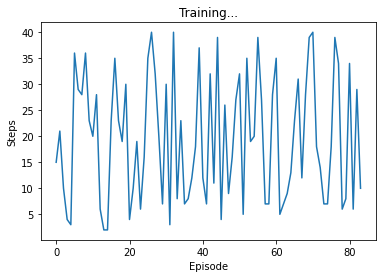

Running episode 46, training on map 5
0.1 0.1 0.0 0.0 
0.1 0.1 0.0 0.0 
0.0 0.0 0.0 1.0 
2.0 2.0 0.0 0.0 

Optimizing on map 8
Optimizing on map 3
Optimizing on map 7
Optimizing on map 0
Optimizing on map 7
reached_terminal
Optimizing on map 7


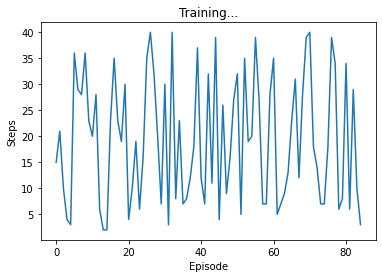

Running episode 47, training on map 10
0.0 0.0 2.0 2.0 0.0 
0.0 0.1 0.1 0.1 0.0 
0.0 0.1 0.1 0.1 1.0 
0.0 0.1 0.1 0.1 1.0 
0.0 0.0 0.0 0.0 1.0 

Optimizing on map 5
Optimizing on map 4
Optimizing on map 7
Optimizing on map 8
Optimizing on map 9
Optimizing on map 6
Optimizing on map 7
Optimizing on map 4
reached_terminal
Optimizing on map 2


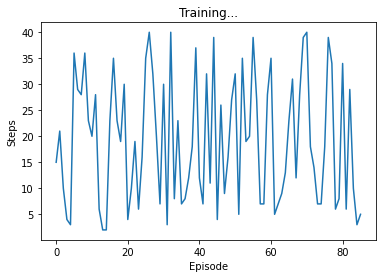

Running episode 48, training on map 3
1.0 2.0 0.0 
0.0 0.0 0.0 
0.0 0.1 0.1 

Optimizing on map 4
Optimizing on map 1
Optimizing on map 6
Optimizing on map 2
Optimizing on map 2
Optimizing on map 2
Optimizing on map 4
Optimizing on map 0
Optimizing on map 2
Optimizing on map 4
Optimizing on map 8
Optimizing on map 2
Optimizing on map 6
Optimizing on map 5
Optimizing on map 9
Optimizing on map 10
Optimizing on map 2
Optimizing on map 7
Optimizing on map 8
Optimizing on map 10
Optimizing on map 4
Optimizing on map 0
Optimizing on map 10
Optimizing on map 3
Optimizing on map 2
Optimizing on map 5
Optimizing on map 6
Optimizing on map 3
Optimizing on map 4
Optimizing on map 0
Optimizing on map 3
Optimizing on map 9
Optimizing on map 0
Optimizing on map 4
Optimizing on map 4
Optimizing on map 2
Optimizing on map 0
Optimizing on map 1
Optimizing on map 8
Optimizing on map 5
Optimizing on map 1
Optimizing on map 2
Optimizing on map 1
Optimizing on map 1
Optimizing on map 4
Optimizing on map 1

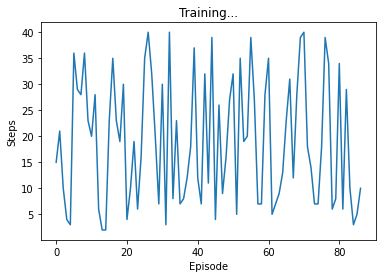

Running episode 50, training on map 0
1.0 0.0 
0.0 0.1 

Optimizing on map 7
Optimizing on map 1
Optimizing on map 4
Optimizing on map 0
Optimizing on map 4
Optimizing on map 3
Optimizing on map 2
Optimizing on map 5
Optimizing on map 8
Optimizing on map 5
Optimizing on map 8
Optimizing on map 6
Optimizing on map 7
Optimizing on map 5
Optimizing on map 2
Optimizing on map 2
Optimizing on map 8
Optimizing on map 8
Optimizing on map 5
Optimizing on map 9
Optimizing on map 10
Optimizing on map 2
Optimizing on map 8
Optimizing on map 0
Optimizing on map 7
Optimizing on map 0
Optimizing on map 7
Optimizing on map 3
Optimizing on map 4
Optimizing on map 2
Optimizing on map 10
Optimizing on map 5
Optimizing on map 9
Optimizing on map 7
Optimizing on map 2
Optimizing on map 8
Optimizing on map 0
Optimizing on map 1
Optimizing on map 8
Optimizing on map 1
Optimizing on map 10
Running episode 51, training on map 1
0.1 0.0 0.0 
0.0 0.0 0.0 
0.0 0.0 1.0 

Optimizing on map 4
Optimizing on map 0
Op

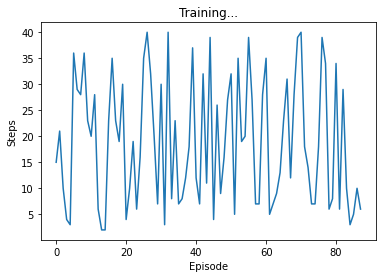

Running episode 55, training on map 0
1.0 0.0 
0.0 0.1 

Optimizing on map 1
Optimizing on map 2
Optimizing on map 6
Optimizing on map 5
Optimizing on map 9
Optimizing on map 3
Optimizing on map 2
Optimizing on map 1
Optimizing on map 2
Optimizing on map 6
Optimizing on map 0
Optimizing on map 4
Optimizing on map 4
Optimizing on map 8
Optimizing on map 6
Optimizing on map 2
Optimizing on map 0
Optimizing on map 0
Optimizing on map 2
Optimizing on map 10
Optimizing on map 2
Optimizing on map 6
Optimizing on map 1
Optimizing on map 7
Optimizing on map 10
Optimizing on map 2
Optimizing on map 4
Optimizing on map 6
Optimizing on map 4
Optimizing on map 8
Optimizing on map 5
Optimizing on map 9
Optimizing on map 10
Optimizing on map 0
Optimizing on map 2
Optimizing on map 8
Optimizing on map 4
Optimizing on map 1
Optimizing on map 10
Optimizing on map 4
Optimizing on map 10
Running episode 56, training on map 7
0.0 0.0 0.0 0.0 4.0 4.0 
0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.1 0.1 0.0 0.0 
0.0 0

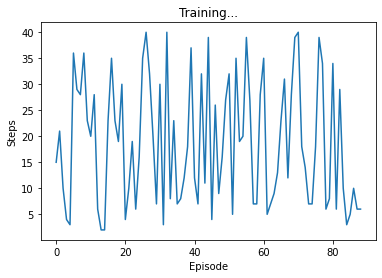

Running episode 57, training on map 5
0.1 0.1 0.0 0.0 
0.1 0.1 0.0 0.0 
0.0 0.0 0.0 1.0 
2.0 2.0 0.0 0.0 

Optimizing on map 0
Optimizing on map 2
Optimizing on map 2
Optimizing on map 1
Optimizing on map 3
Optimizing on map 2
Optimizing on map 7
Optimizing on map 7
Optimizing on map 3
Optimizing on map 3
Optimizing on map 6
Optimizing on map 0
Optimizing on map 9
Optimizing on map 7
Optimizing on map 2
Optimizing on map 7
Optimizing on map 9
Optimizing on map 6
Optimizing on map 2
Optimizing on map 3
Optimizing on map 4
Optimizing on map 10
Optimizing on map 8
Optimizing on map 2
Optimizing on map 1
Optimizing on map 4
reached_terminal
Optimizing on map 9


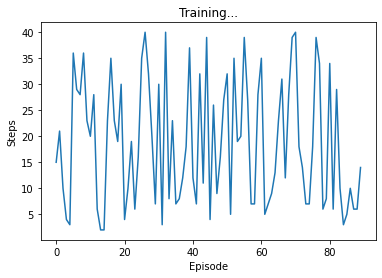

Running episode 58, training on map 2
0.0 0.0 0.1 
0.0 0.0 0.0 
1.0 0.0 0.0 

Optimizing on map 8
Optimizing on map 3
Optimizing on map 2
Optimizing on map 10
Optimizing on map 1
Optimizing on map 10
Optimizing on map 5
Optimizing on map 10
Optimizing on map 0
Optimizing on map 6
Optimizing on map 10
Optimizing on map 1
Optimizing on map 5
Optimizing on map 8
Optimizing on map 4
Optimizing on map 1
Optimizing on map 9
Optimizing on map 0
Optimizing on map 3
Optimizing on map 8
Optimizing on map 4
Optimizing on map 5
Optimizing on map 1
Optimizing on map 5
Optimizing on map 5
Optimizing on map 5
Optimizing on map 2
Optimizing on map 8
Optimizing on map 1
Optimizing on map 8
Optimizing on map 6
Optimizing on map 7
Optimizing on map 1
Optimizing on map 1
Optimizing on map 6
Optimizing on map 9
Optimizing on map 9
Optimizing on map 10
Optimizing on map 7
Optimizing on map 0
Optimizing on map 9
Running episode 59, training on map 8
0.0 0.0 4.0 4.0 4.0 4.0 
0.0 0.0 0.0 0.0 0.0 0.0 
0.1 0.1 0

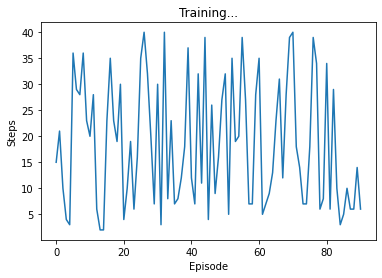

Running episode 64, training on map 1
0.1 0.0 0.0 
0.0 0.0 0.0 
0.0 0.0 1.0 

Optimizing on map 3
Optimizing on map 2
Optimizing on map 4
Optimizing on map 8
Optimizing on map 10
Optimizing on map 10
Optimizing on map 2
Optimizing on map 1
Optimizing on map 5
Optimizing on map 9
Optimizing on map 7
Optimizing on map 7
Optimizing on map 3
Optimizing on map 5
Optimizing on map 6
Optimizing on map 1
Optimizing on map 3
Optimizing on map 0
Optimizing on map 8
Optimizing on map 8
Optimizing on map 9
Optimizing on map 6
Optimizing on map 9
Optimizing on map 2
Optimizing on map 2
Optimizing on map 2
Optimizing on map 6
Optimizing on map 4
Optimizing on map 2
Optimizing on map 10
Optimizing on map 8
Optimizing on map 10
Optimizing on map 1
Optimizing on map 1
Optimizing on map 4
Optimizing on map 0
Optimizing on map 6
Optimizing on map 7
Optimizing on map 6
Optimizing on map 3
Optimizing on map 10
Running episode 65, training on map 0
1.0 0.0 
0.0 0.1 

Optimizing on map 8
Optimizing on map 4


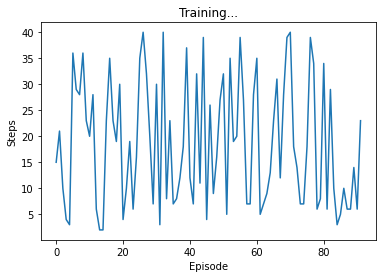

Running episode 67, training on map 6
1.0 2.0 2.0 0.0 
1.0 1.0 0.0 0.0 
0.0 0.1 0.1 0.1 
0.0 0.1 0.1 0.1 

Optimizing on map 0
Optimizing on map 10
Optimizing on map 6
Optimizing on map 7
Optimizing on map 1
Optimizing on map 4
Optimizing on map 10
Optimizing on map 7
Optimizing on map 9
Optimizing on map 7
Optimizing on map 3
Optimizing on map 3
Optimizing on map 7
Optimizing on map 3
Optimizing on map 3
Optimizing on map 7
Optimizing on map 3
Optimizing on map 6
Optimizing on map 2
Optimizing on map 1
Optimizing on map 10
Optimizing on map 2
Optimizing on map 5
Optimizing on map 7
Optimizing on map 8
Optimizing on map 7
Optimizing on map 7
Optimizing on map 4
Optimizing on map 9
Optimizing on map 2
Optimizing on map 6
Optimizing on map 5
Optimizing on map 2
Optimizing on map 1
Optimizing on map 5
Optimizing on map 2
Optimizing on map 5
Optimizing on map 7
Optimizing on map 7
Optimizing on map 7
Optimizing on map 3
Optimizing on map 3
Optimizing on map 0
Optimizing on map 10
Optimizin

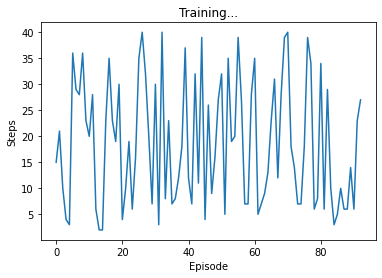

Running episode 68, training on map 1
0.1 0.0 0.0 
0.0 0.0 0.0 
0.0 0.0 1.0 

Optimizing on map 10
Optimizing on map 4
Optimizing on map 2
Optimizing on map 4
Optimizing on map 3
Optimizing on map 2
Optimizing on map 10
Optimizing on map 2
Optimizing on map 5
Optimizing on map 0
Optimizing on map 1
Optimizing on map 7
Optimizing on map 1
Optimizing on map 1
Optimizing on map 4
Optimizing on map 3
Optimizing on map 5
Optimizing on map 0
Optimizing on map 3
Optimizing on map 5
Optimizing on map 4
Optimizing on map 7
Optimizing on map 0
Optimizing on map 5
Optimizing on map 4
Optimizing on map 1
Optimizing on map 1
Optimizing on map 5
Optimizing on map 9
Optimizing on map 5
Optimizing on map 9
Optimizing on map 6
Optimizing on map 3
Optimizing on map 3
Optimizing on map 6
Optimizing on map 5
Optimizing on map 4
Optimizing on map 1
Optimizing on map 0
Optimizing on map 6
Optimizing on map 2
Running episode 69, training on map 2
0.0 0.0 0.1 
0.0 0.0 0.0 
1.0 0.0 0.0 

Optimizing on map 4
Op

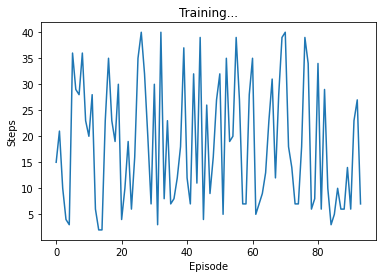

Running episode 74, training on map 10
0.0 0.0 2.0 2.0 0.0 
0.0 0.1 0.1 0.1 0.0 
0.0 0.1 0.1 0.1 1.0 
0.0 0.1 0.1 0.1 1.0 
0.0 0.0 0.0 0.0 1.0 

Optimizing on map 7
Optimizing on map 8
Optimizing on map 3
Optimizing on map 3
Optimizing on map 1
Optimizing on map 4
Optimizing on map 5
Optimizing on map 3
Optimizing on map 6
Optimizing on map 10
Optimizing on map 7
Optimizing on map 7
Optimizing on map 4
Optimizing on map 3
Optimizing on map 7
Optimizing on map 7
Optimizing on map 0
Optimizing on map 2
Optimizing on map 0
Optimizing on map 5
Optimizing on map 10
Optimizing on map 1
Optimizing on map 2
Optimizing on map 3
Optimizing on map 7
Optimizing on map 10
Optimizing on map 4
Optimizing on map 4
Optimizing on map 4
Optimizing on map 9
Optimizing on map 0
Optimizing on map 5
Optimizing on map 5
Optimizing on map 4
Optimizing on map 4
Optimizing on map 8
Optimizing on map 0
Optimizing on map 3
Optimizing on map 9
Optimizing on map 8
Optimizing on map 7
Optimizing on map 4
Optimizing o

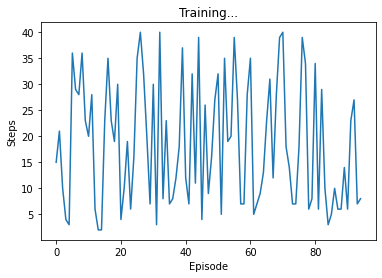

Running episode 76, training on map 2
0.0 0.0 0.1 
0.0 0.0 0.0 
1.0 0.0 0.0 

Optimizing on map 5
Optimizing on map 6
Optimizing on map 4
Optimizing on map 6
Optimizing on map 10
Optimizing on map 4
Optimizing on map 7
Optimizing on map 2
Optimizing on map 8
Optimizing on map 1
Optimizing on map 9
Optimizing on map 4
Optimizing on map 9
Optimizing on map 4
Optimizing on map 5
Optimizing on map 5
Optimizing on map 8
Optimizing on map 10
Optimizing on map 9
Optimizing on map 7
Optimizing on map 6
Optimizing on map 6
Optimizing on map 8
Optimizing on map 4
Optimizing on map 5
Optimizing on map 9
Optimizing on map 1
Optimizing on map 3
Optimizing on map 2
Optimizing on map 0
Optimizing on map 10
Optimizing on map 2
Optimizing on map 9
Optimizing on map 5
Optimizing on map 9
Optimizing on map 3
Optimizing on map 0
Optimizing on map 5
Optimizing on map 4
Optimizing on map 8
Optimizing on map 5
Running episode 77, training on map 1
0.1 0.0 0.0 
0.0 0.0 0.0 
0.0 0.0 1.0 

Optimizing on map 10


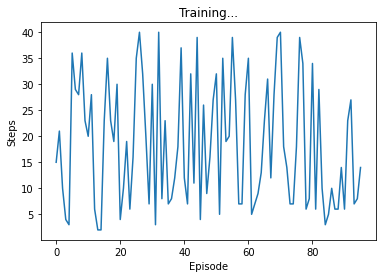

Running episode 78, training on map 10
0.0 0.0 2.0 2.0 0.0 
0.0 0.1 0.1 0.1 0.0 
0.0 0.1 0.1 0.1 1.0 
0.0 0.1 0.1 0.1 1.0 
0.0 0.0 0.0 0.0 1.0 

Optimizing on map 5
Optimizing on map 2
Optimizing on map 9
Optimizing on map 9
Optimizing on map 6
Optimizing on map 0
Optimizing on map 2
Optimizing on map 8
Optimizing on map 7
Optimizing on map 9
Optimizing on map 8
Optimizing on map 3
Optimizing on map 10
Optimizing on map 1
Optimizing on map 6
Optimizing on map 3
Optimizing on map 0
Optimizing on map 5
Optimizing on map 8
Optimizing on map 6
Optimizing on map 8
Optimizing on map 9
Optimizing on map 3
Optimizing on map 5
Optimizing on map 1
Optimizing on map 5
Optimizing on map 9
Optimizing on map 8
Optimizing on map 2
Optimizing on map 3
Optimizing on map 9
Optimizing on map 10
Optimizing on map 0
Optimizing on map 7
Optimizing on map 6
Optimizing on map 4
Optimizing on map 4
Optimizing on map 2
Optimizing on map 3
Optimizing on map 5
Optimizing on map 3
Optimizing on map 9
Optimizing on

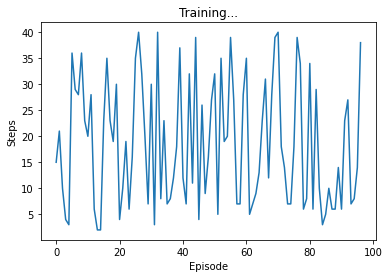

Running episode 79, training on map 8
0.0 0.0 4.0 4.0 4.0 4.0 
0.0 0.0 0.0 0.0 0.0 0.0 
0.1 0.1 0.1 0.1 0.1 0.0 
0.1 0.1 0.1 0.1 0.1 0.0 
0.0 0.0 0.0 0.0 0.0 1.0 
0.0 0.0 0.0 0.0 0.0 1.0 

Optimizing on map 7
Optimizing on map 9
Optimizing on map 1
Optimizing on map 1
Optimizing on map 4
Optimizing on map 2
Optimizing on map 0
Optimizing on map 6
Optimizing on map 1
Optimizing on map 3
Optimizing on map 5
Optimizing on map 4
Optimizing on map 10
Optimizing on map 6
Optimizing on map 7
Optimizing on map 5
Optimizing on map 2
Optimizing on map 4
Optimizing on map 8
Optimizing on map 1
Optimizing on map 6
Optimizing on map 7
Optimizing on map 9
Optimizing on map 1
Optimizing on map 10
Optimizing on map 0
Optimizing on map 9
Optimizing on map 9
Optimizing on map 3
Optimizing on map 6
Optimizing on map 0
Optimizing on map 9
Optimizing on map 7
Optimizing on map 8
Optimizing on map 3
Optimizing on map 5
Optimizing on map 9
Optimizing on map 0
Optimizing on map 0
Optimizing on map 5
Optimizin

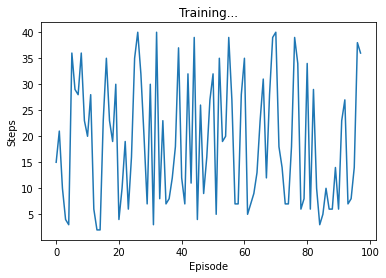

Running episode 83, training on map 4
0.0 0.0 1.0 
0.0 2.0 0.0 
0.0 0.1 0.1 

Optimizing on map 1
Optimizing on map 8
Optimizing on map 7
Optimizing on map 5
Optimizing on map 9
Optimizing on map 8
Optimizing on map 2
Optimizing on map 1
Optimizing on map 0
Optimizing on map 2
Optimizing on map 3
Optimizing on map 9
Optimizing on map 3
Optimizing on map 5
Optimizing on map 2
Optimizing on map 8
Optimizing on map 7
Optimizing on map 10
Optimizing on map 3
Optimizing on map 0
Optimizing on map 4
Optimizing on map 7
Optimizing on map 9
Optimizing on map 9
Optimizing on map 2
Optimizing on map 1
Optimizing on map 5
Optimizing on map 2
Optimizing on map 1
Optimizing on map 0
Optimizing on map 9
Optimizing on map 0
Optimizing on map 8
Optimizing on map 5
Optimizing on map 6
Optimizing on map 5
Optimizing on map 1
Optimizing on map 8
Optimizing on map 9
Optimizing on map 3
Optimizing on map 6
Optimizing on map 2
Optimizing on map 6
Optimizing on map 3
Optimizing on map 8
Optimizing on map 4
O

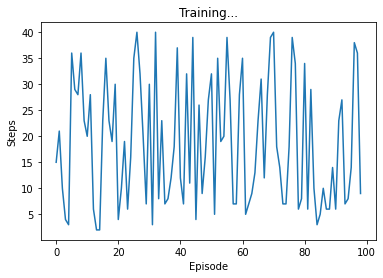

Running episode 85, training on map 3
1.0 2.0 0.0 
0.0 0.0 0.0 
0.0 0.1 0.1 

Optimizing on map 0
Optimizing on map 1
Optimizing on map 3
Optimizing on map 1
Optimizing on map 1
Optimizing on map 10
Optimizing on map 0
Optimizing on map 10
Optimizing on map 5
Optimizing on map 3
Optimizing on map 7
Optimizing on map 3
Optimizing on map 5
Optimizing on map 9
Optimizing on map 5
Optimizing on map 10
Optimizing on map 10
Optimizing on map 10
Optimizing on map 4
Optimizing on map 5
Optimizing on map 8
Optimizing on map 8
Optimizing on map 9
Optimizing on map 4
Optimizing on map 9
Optimizing on map 2
Optimizing on map 3
Optimizing on map 1
Optimizing on map 1
Optimizing on map 8
Optimizing on map 0
Optimizing on map 4
Optimizing on map 7
Optimizing on map 0
Optimizing on map 9
Optimizing on map 10
Optimizing on map 4
Optimizing on map 5
Optimizing on map 0
Optimizing on map 6
Optimizing on map 8
Optimizing on map 1
Optimizing on map 2
Optimizing on map 3
Optimizing on map 1
Optimizing on ma

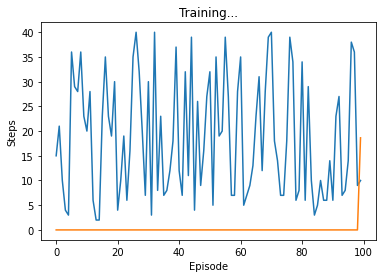

Running episode 88, training on map 2
0.0 0.0 0.1 
0.0 0.0 0.0 
1.0 0.0 0.0 

Optimizing on map 5
Optimizing on map 4
Optimizing on map 1
Optimizing on map 4
Optimizing on map 4
Optimizing on map 6
Optimizing on map 2
Optimizing on map 5
Optimizing on map 3
Optimizing on map 3
Optimizing on map 2
Optimizing on map 3
Optimizing on map 10
Optimizing on map 4
Optimizing on map 9
Optimizing on map 5
Optimizing on map 1
Optimizing on map 4
Optimizing on map 1
Optimizing on map 0
Optimizing on map 5
Optimizing on map 5
Optimizing on map 3
Optimizing on map 8
Optimizing on map 0
Optimizing on map 1
Optimizing on map 10
Optimizing on map 5
Optimizing on map 8
Optimizing on map 5
Optimizing on map 7
Optimizing on map 3
Optimizing on map 0
Optimizing on map 7
Optimizing on map 0
Optimizing on map 7
Optimizing on map 7
Optimizing on map 1
Optimizing on map 6
Optimizing on map 5
Optimizing on map 4
Running episode 89, training on map 5
0.1 0.1 0.0 0.0 
0.1 0.1 0.0 0.0 
0.0 0.0 0.0 1.0 
2.0 2.0 0.0

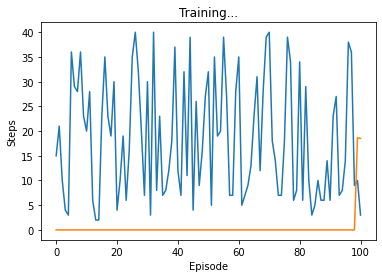

Running episode 90, training on map 1
0.1 0.0 0.0 
0.0 0.0 0.0 
0.0 0.0 1.0 

Optimizing on map 3
Optimizing on map 0
Optimizing on map 2
Optimizing on map 6
Optimizing on map 10
Optimizing on map 3
Optimizing on map 7
Optimizing on map 1
Optimizing on map 4
Optimizing on map 9
Optimizing on map 10
Optimizing on map 10
Optimizing on map 5
Optimizing on map 2
Optimizing on map 2
Optimizing on map 2
Optimizing on map 3
Optimizing on map 7
Optimizing on map 5
Optimizing on map 8
Optimizing on map 5
Optimizing on map 8
Optimizing on map 5
Optimizing on map 9
Optimizing on map 8
Optimizing on map 1
Optimizing on map 3
Optimizing on map 7
Optimizing on map 3
Optimizing on map 7
Optimizing on map 0
Optimizing on map 6
Optimizing on map 5
Optimizing on map 9
Optimizing on map 2
reached_terminal
Optimizing on map 6


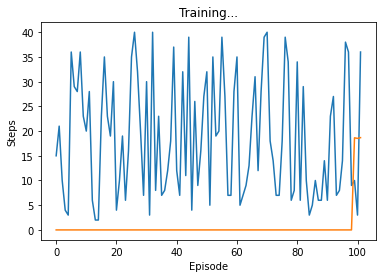

Running episode 91, training on map 6
1.0 2.0 2.0 0.0 
1.0 1.0 0.0 0.0 
0.0 0.1 0.1 0.1 
0.0 0.1 0.1 0.1 

Optimizing on map 0
Optimizing on map 3
Optimizing on map 8
Optimizing on map 4
Optimizing on map 6
Optimizing on map 1
Optimizing on map 4
Optimizing on map 8
Optimizing on map 4
Optimizing on map 0
Optimizing on map 2
Optimizing on map 10
Optimizing on map 8
Optimizing on map 6
Optimizing on map 6
Optimizing on map 5
Optimizing on map 10
Optimizing on map 6
Optimizing on map 2
Optimizing on map 4
Optimizing on map 10
Optimizing on map 5
Optimizing on map 0
Optimizing on map 3
Optimizing on map 0
Optimizing on map 9
Optimizing on map 8
Optimizing on map 6
Optimizing on map 1
Optimizing on map 4
Optimizing on map 8
Optimizing on map 6
Optimizing on map 5
Optimizing on map 0
Optimizing on map 10
Optimizing on map 3
Optimizing on map 8
Optimizing on map 8
Optimizing on map 8
Optimizing on map 10
Optimizing on map 8
Optimizing on map 7
Optimizing on map 8
Optimizing on map 0
Optimizi

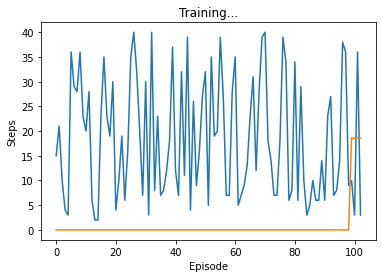

Running episode 94, training on map 2
0.0 0.0 0.1 
0.0 0.0 0.0 
1.0 0.0 0.0 

Optimizing on map 1
Optimizing on map 0
Optimizing on map 3
Optimizing on map 10
Optimizing on map 2
Optimizing on map 9
Optimizing on map 2
Optimizing on map 8
Optimizing on map 0
Optimizing on map 7
Optimizing on map 5
Optimizing on map 2
Optimizing on map 4
Optimizing on map 0
Optimizing on map 6
Optimizing on map 8
Optimizing on map 8
Optimizing on map 6
Optimizing on map 6
Optimizing on map 0
Optimizing on map 6
Optimizing on map 5
Optimizing on map 4
Optimizing on map 10
Optimizing on map 8
Optimizing on map 1
Optimizing on map 10
Optimizing on map 10
Optimizing on map 10
Optimizing on map 2
Optimizing on map 8
Optimizing on map 10
Optimizing on map 2
Optimizing on map 4
Optimizing on map 7
Optimizing on map 6
Optimizing on map 5
Optimizing on map 5
Optimizing on map 1
Optimizing on map 3
Optimizing on map 0
Running episode 95, training on map 10
0.0 0.0 2.0 2.0 0.0 
0.0 0.1 0.1 0.1 0.0 
0.0 0.1 0.1 0.1

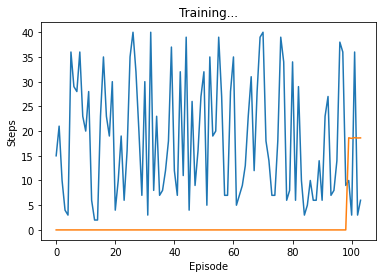

Running episode 97, training on map 7
0.0 0.0 0.0 0.0 4.0 4.0 
0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.1 0.1 0.0 0.0 
0.0 0.0 0.1 0.1 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 
2.0 2.0 0.0 0.0 0.0 0.0 

Optimizing on map 1
Optimizing on map 8
Optimizing on map 2
Optimizing on map 4
Optimizing on map 3
Optimizing on map 5
Optimizing on map 5
Optimizing on map 10
Optimizing on map 10
Optimizing on map 2
Optimizing on map 3
Optimizing on map 4
Optimizing on map 5
Optimizing on map 5
Optimizing on map 8
reached_terminal
Optimizing on map 10


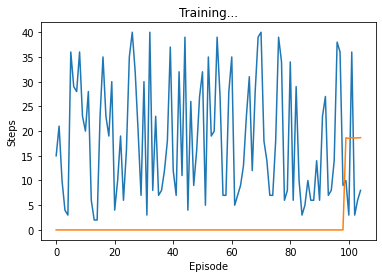

Running episode 98, training on map 4
0.0 0.0 1.0 
0.0 2.0 0.0 
0.0 0.1 0.1 

Optimizing on map 10
Optimizing on map 9
Optimizing on map 2
Optimizing on map 3
Optimizing on map 7
Optimizing on map 2
Optimizing on map 1
Optimizing on map 7
Optimizing on map 1
Optimizing on map 3
Optimizing on map 0
Optimizing on map 8
Optimizing on map 9
Optimizing on map 6
Optimizing on map 3
Optimizing on map 5
Optimizing on map 5
Optimizing on map 0
Optimizing on map 3
Optimizing on map 7
Optimizing on map 0
Optimizing on map 3
Optimizing on map 9
Optimizing on map 5
Optimizing on map 5
Optimizing on map 4
Optimizing on map 6
Optimizing on map 1
Optimizing on map 9
Optimizing on map 1
Optimizing on map 8
Optimizing on map 0
Optimizing on map 6
Optimizing on map 2
Optimizing on map 8
Optimizing on map 3
Optimizing on map 9
Optimizing on map 6
Optimizing on map 4
Optimizing on map 1
Optimizing on map 1
Optimizing on map 3
Optimizing on map 3
Optimizing on map 7
Optimizing on map 6
Optimizing on map 9
O

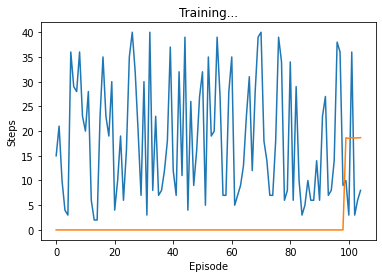

Complete


In [37]:
import random
memory_replays = [ReplayMemory(MEMORY_SIZE) for i in range(11)]
for episode in range(100): # number of episodes
  map_n = random.randint(0, 10) # choosing radndom map to train on for each episode
  print(f'Running episode {episode}, training on map {map_n}')
  world = World(rf"{map_n}.txt", r"outfile.txt")
  world.print_grid()
  state = torch.tensor(world.get_current_grid())
  cargo = world.cargos[list(world.cargos.keys())[0]]
  cargo_number = list(world.cargos.keys())[0]
  state = merge_grid_with_cargo(state, world.desirable_area, cargo, cargo_number, world.grid_h, world.grid_w, world)
  for t in count():
    if t > 40:
      break
    done = False
    for cargo_number, cargo in world.cargos.items():
      action = select_action(state.unsqueeze(0))
      action = int(action.item())
      move_done, reward, done= world.step(action, cargo_number)
      reward = torch.tensor([reward], device=device)
      # print(m[action], cargo_number, reward, done)
      # world.print_grid()
      # Observe new state
      if not done:
          next_state = torch.tensor(world.get_current_grid())
          next_cargo_number = get_next_cargo(world, cargo_number)
          next_state = merge_grid_with_cargo(
              next_state, world.desirable_area, world.cargos[next_cargo_number]
              , next_cargo_number, world.grid_h, world.grid_w, world
              )
          # Store the transition in memory
          memory_replays[map_n].push(state.unsqueeze(0), action, next_state.unsqueeze(0), reward)
      else:
          next_state = None
          memory_replays[map_n].push(state.unsqueeze(0), action, next_state, reward)

      # Move to the next state
      state = next_state

      # Perform one step of the optimization (on the policy network)
      n_map = random.randint(0, 10) 
      if len(memory_replays[n_map]) >= BATCH_SIZE:
        print(f"Optimizing on map {n_map}")

      optimize_model(memory_replays[n_map])
      # Update the target network, copying all weights and biases in DQN
      if t % TARGET_UPDATE == 0:
          target_net.load_state_dict(policy_net.state_dict())
      if done:
          break
    if done:
        episode_durations.append(t + 1)
        plot_durations()
        break
plot_durations()
print('Complete')
plt.ioff()
plt.show()

In [18]:
path1 = 'policy_net.pt'
path2 = 'target_net.pt'
torch.save(policy_net.state_dict(), path1)
torch.save(target_net.state_dict(), path2)

In [39]:
def test():
    """
    used to test the model on the example in the problem statment
    """
    world = World(r"10.txt", r"outfile.txt")
    target_net.eval()
    state = torch.tensor(world.get_current_grid())
    cargo = world.cargos[list(world.cargos.keys())[0]]
    cargo_number = list(world.cargos.keys())[0]
    state = merge_grid_with_cargo(state, world.desirable_area, cargo, (cargo_number), world.grid_h, world.grid_w,world)
    m = {
        0: 'rest',
        1: 'up',
        2: 'down',
        3: 'right',
        4: 'left'
    }
    for t in count():
        print(f'step: {t}')
        if t > 20:
            break
        # Select and perform an action for each cargo
        done = False
        for cargo_number, cargo in world.cargos.items():
            with torch.no_grad():
                action = target_net(state.unsqueeze(0)).max(1)[1].view(1, 1)
            action = int(action.item())
            move_done, reward, done= world.step(action, cargo_number)
            reward = torch.tensor([reward], device=device)
            print(m[action], cargo_number, reward, done)
            world.print_grid()

            # Observe new state
            if not done:
                next_state = torch.tensor(world.get_current_grid())
                next_cargo_number = get_next_cargo(world, cargo_number)
                next_state = merge_grid_with_cargo(next_state, world.desirable_area, world.cargos[next_cargo_number], (next_cargo_number), world.grid_h, world.grid_w, world)
            else:
                next_state = None
            
            # Move to the next state
            state = next_state

test()

step: 0
down 2.0 tensor([2], device='cuda:0') False
0.0 0.0 0.0 0.0 0.0 
0.0 0.1 0.1 0.1 0.0 
0.0 0.1 0.1 0.1 1.0 
0.0 0.1 0.1 0.1 1.0 
0.0 0.0 0.0 0.0 1.0 

left 1.0 tensor([4], device='cuda:0') False
0.0 0.0 0.0 0.0 0.0 
0.0 0.1 0.1 0.1 0.0 
0.0 0.1 0.1 0.1 0.0 
0.0 0.1 0.1 0.1 0.0 
0.0 0.0 0.0 1.0 0.0 

step: 1
left 2.0 tensor([4], device='cuda:0') False
0.0 0.0 0.0 0.0 0.0 
0.0 0.1 0.1 0.1 0.0 
0.0 0.1 0.1 0.1 0.0 
0.0 0.1 0.1 0.1 0.0 
0.0 0.0 0.0 1.0 0.0 

left 1.0 tensor([4], device='cuda:0') False
0.0 0.0 0.0 0.0 0.0 
0.0 0.1 0.1 0.1 0.0 
0.0 0.1 0.1 0.1 0.0 
0.0 0.1 0.1 0.1 0.0 
0.0 0.0 1.0 0.0 0.0 

step: 2
right 2.0 tensor([4], device='cuda:0') False
0.0 0.0 0.0 0.0 0.0 
0.0 0.1 0.1 0.1 0.0 
0.0 0.1 0.1 0.1 0.0 
0.0 0.1 0.1 0.1 0.0 
0.0 0.0 1.0 0.0 0.0 

left 1.0 tensor([4], device='cuda:0') False
0.0 0.0 0.0 0.0 0.0 
0.0 0.1 0.1 0.1 0.0 
0.0 0.1 0.1 0.1 0.0 
0.0 0.1 0.1 0.1 0.0 
0.0 1.0 0.0 0.0 0.0 

step: 3
left 2.0 tensor([4], device='cuda:0') False
0.0 0.0 0.0 0.0 0.0 
0.